https://scikit-learn.org/stable/modules/grid_search.html#multimetric-grid-search 

No precision / divide_by_zero warnings==> DO NOT specify cv with GridSearchCV. Ok to specify  with crossvalidation evaluation of the best found estimator. 

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification, make_blobs
from sklearn.datasets import load_iris
from sklearn.datasets import load_digits
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import validation_curve
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold


from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
#from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


from matplotlib.colors import ListedColormap

#from adspy_shared_utilities import plot_feature_importances
#from adspy_shared_utilities import plot_decision_tree
#from adspy_shared_utilities import plot_class_regions_for_classifier
#from adspy_shared_utilities import plot_class_regions_for_classifier_subplot
#from adspy_shared_utilities import plot_fruit_knn

---
IRIS (3 class dataset)
---
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py

In [2]:
from sklearn import metrics
print (sorted(metrics.SCORERS.keys()) )

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'top_k_accuracy', 'v_measure_score']


In [3]:
# dataset
iris = load_iris()
iris_df = pd.DataFrame(iris.data)
iris_df.columns = iris.feature_names
iris_df['target'] = pd.Series(iris.target)
print (iris_df.head(3))

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   

   target  
0       0  
1       0  
2       0  


In [4]:
X_iris = pd.DataFrame(iris.data)
X_iris.columns = iris.feature_names
y_iris = pd.Series(iris.target)

In [5]:
# Split the dataset in two equal parts
targets = np.array(y_iris)
X_train, X_test, y_train, y_test = train_test_split(X_iris,
                                                    y_iris, 
                                                    test_size=0.5, # defaults to .75
                                                    stratify=targets,# consistent class distribution between train and test sets 
                                                    random_state=0)

print('y_train class distribution')
print(y_train.value_counts(normalize=True))
print('y_test class distribution')
print(y_test.value_counts(normalize=True))

y_train class distribution
0    0.333333
1    0.333333
2    0.333333
dtype: float64
y_test class distribution
2    0.333333
1    0.333333
0    0.333333
dtype: float64


    Summary from the sklearn/metrics/_classification.py code:
    When ``true positive + false positive == 0``, precision is undefined. 
    When ``true positive + false negative == 0``, recall is undefined. 
    In such cases, by default the metric will be set to 0, as will f-score, and ``UndefinedMetricWarning`` will be raised. This behavior can be modified with ``zero_division``.
    
    https://stackoverflow.com/questions/66538197/precision-calculation-warning-when-using-gridsearchcv-for-logistic-regression
        precision warning messages: "I used GridSearchCV to find the best hyperparameters for the model. To view the model metrics for each split, I create a StratifedKFold estimator with the best hyperparameters and then did cross validation on its own. This gave me no precision warning messages. I have no idea why GridSearchCV is giving me a warning but atleast this way works!!!"

In [6]:
# Set the parameters by cross-validation
tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [1e-2, 1e-3, 1e-4], "C": [0.01, 0.1,1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
]

# "Remove roc_auc if it is multi class. 
# They do not play well together. Use default scoring or choose something else."

# The scorers can be either one of the predefined metric strings or a scorer
# callable, like the one returned by make_scorer
#scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}
#scores = {
#    'precision': make_scorer(precision_score, zero_division=0) # limit the number of false positives
    #'recall_score': make_scorer(recall_score),
    #'accuracy_score': make_scorer(accuracy_score)}
scores = ["precision", "recall", "f1"]

for score in scores:
    print ("-----------------------------------------------------------------")
    print (score)
    print("# ...Tuning hyper-parameters for %s" % score)
    print()
    clf = GridSearchCV(SVC(), 
                       tuned_parameters, 
                       return_train_score=True, # computationaly expensive, not strictly required. defaults to False
                       refit = "f1", 
                       scoring="%s_weighted" % score, #scoring="%s_micro" % score, #scoring="%s_macro" % score, 
                       n_jobs = -1,
                       error_score = "raise")
                     
    clf.fit(X_train, y_train)
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, 
                                zero_division=0) )
    print()

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

-----------------------------------------------------------------
precision
# ...Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

Grid scores on development set:

0.913 (+/-0.058) for {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
0.929 (+/-0.039) for {'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}
0.929 (+/-0.039) for {'C': 0.01, 'gamma': 0.0001, 'kernel': 'rbf'}
0.913 (+/-0.058) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.929 (+/-0.039) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.929 (+/-0.039) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.929 (+/-0.039) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.929 (+/-0.039) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.929 (+/-0.039) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.948 (+/-0.061) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.921 (+/-0.039) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.929 (+/-0.039) for {'C': 10, 'gamma': 0.0001,


     Example of PLOTTING THE RESULT

    https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py

In [7]:
results = clf.cv_results_
print (results.keys())

print ("")
print (results['params'])

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_gamma', 'param_kernel', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

[{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}, {'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}, {'C': 0.01, 'gamma': 0.0001, 'kernel': 'rbf'}, {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}, {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}, {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}, {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}, {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}, {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}, {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}, {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}, {'C': 100, 'gamma': 

In [8]:
tried_C = np.array(results["param_C"], dtype = "float")
print (tried_C)
print (max(tried_C))
print (min(tried_C))

[1.e-02 1.e-02 1.e-02 1.e-01 1.e-01 1.e-01 1.e+00 1.e+00 1.e+00 1.e+01
 1.e+01 1.e+01 1.e+02 1.e+02 1.e+02 1.e+03 1.e+03 1.e+03 1.e+00 1.e+01
 1.e+02 1.e+03]
1000.0
0.01


In [9]:
zip(sorted(scores))

In [10]:
tried_params = np.array(results["params"], dtype = "str")

tried_C = np.array(results["param_C"], dtype = "float")
tried_gamma = np.array(results["param_gamma"], dtype = "float")
tried_kernels = np.array(results["param_kernel"], dtype = "str")
x_label = "param_C"

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results[x_label], dtype=str)
Y_axis = np.array(results["param_gamma"], dtype=str)

# plotting a 3D scatter plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(X_axis, 
           Y_axis, 
           results["mean_test_score"], 
           #c = y_train, 
           marker = 'o', s=100)
ax.set_xlabel(x_label)
ax.set_ylabel('gamma')
ax.set_zlabel('score')


best_index = np.nonzero(results["rank_test_score"] == 1)[0][0]
best_score = results["mean_test_score"][best_index]
# Plot a dotted vertical line at the best score for that scorer marked by x
ax.scatter(X_axis[best_index], 
           Y_axis[best_index],
           color = "r",
           marker="x")


#plt.legend(loc="best")
plt.grid(False)

plt.show()

<IPython.core.display.Javascript object>

In [11]:
tried_params = np.array(results["params"], dtype = "str")

tried_C = np.array(results["param_C"], dtype = "float")
tried_gamma = np.array(results["param_gamma"], dtype = "float")
tried_kernels = np.array(results["param_kernel"], dtype = "str")
x_label = "param_C"

plt.figure(figsize=(6, 6))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel(x_label)
plt.ylabel("Score")

ax = plt.gca()
#ax.set_xlim(min(tried_C), max(tried_C)/2)
#ax.set_xlin(0, 1000)
#ax.set_ylim(0.73, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results[x_label], dtype=str)
#X_axis = np.array(results["param_gamma"], dtype=str)

scorer = "score"
for kernel, color in zip(tried_kernels, ["b", "r"]):
#for scorer, color in zip(sorted(["score"]), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
        sample_score_std = results["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (%s)" % (scorer, sample),
        )

    best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = results["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

<IPython.core.display.Javascript object>

---
EVALUATION OF THE TUNED MODELS ==> CROSSVALIDATION
---

In [12]:
#number_crossval_folds = 5
#print ( str(number_crossval_folds) +" - fold")


skf = StratifiedKFold(n_splits=3)
# f1 {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
# recall, precision {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

# roc_auc {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
clf = SVC(C= 100,
          gamma = 0.01,
          kernel = 'rbf')

# Evaluate a score by cross-validation
cv_scores = cross_val_score(clf, 
                            X_iris, y_iris, 
                            cv = skf, # cv= number_crossval_folds,
                            scoring = "accuracy")

print('Cross-validation scores:', cv_scores)
print('Mean cross-validation score: {:.3f}'
     .format(np.mean(cv_scores)))

Cross-validation scores: [1.   1.   0.98]
Mean cross-validation score: 0.993


In [13]:
print (sorted(metrics.SCORERS.keys()) )

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'top_k_accuracy', 'v_measure_score']


In [14]:
skf = StratifiedKFold(n_splits=3)
#number_crossval_folds = 3
# run cross-validation on multiple metrics and also to return train scores, fit times and score times.
cv_results = cross_validate(clf, 
                            X_iris, y_iris, 
                            cv = skf, #cv=number_crossval_folds, 
                            scoring=('accuracy', 'precision_macro', 'recall_macro', "f1_macro"))
sorted(cv_results.keys())
cv_results

{'fit_time': array([0.00592399, 0.00314069, 0.00844216]),
 'score_time': array([0.00647712, 0.00944734, 0.01135898]),
 'test_accuracy': array([1.  , 1.  , 0.98]),
 'test_precision_macro': array([1.        , 1.        , 0.98148148]),
 'test_recall_macro': array([1.        , 1.        , 0.98039216]),
 'test_f1_macro': array([1.        , 1.        , 0.98037518])}

    Results on classifier fit with best params found via grid search

<IPython.core.display.Javascript object>


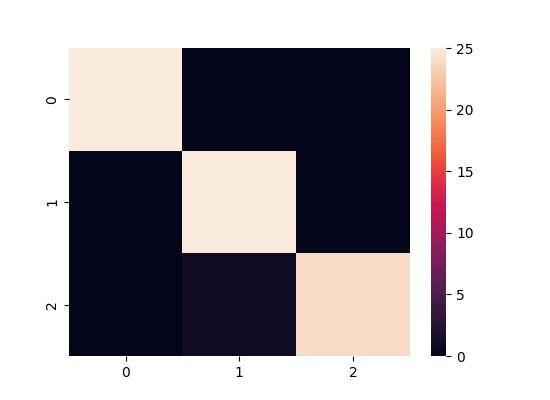


------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       0.96      1.00      0.98        25
           2       1.00      0.96      0.98        25

    accuracy                           0.99        75
   macro avg       0.99      0.99      0.99        75
weighted avg       0.99      0.99      0.99        75



In [15]:
clf = SVC(C= 100,
          gamma = 0.01,
          kernel = 'rbf', 
          probability = True).fit(X_train, 
                              y_train)

predictions = clf.predict(X_test)
confusion = confusion_matrix(y_test, 
                             predictions)

confusionmatrix_df = pd.DataFrame(confusion, 
                     index = [i for i in range(0,len(y_iris.unique()))],
                     columns = [i for i in range(0,len(y_iris.unique()))])

plt.figure(figsize = (5.5,4))
sns.heatmap(confusionmatrix_df, annot=True)
plt.title('SVM RBF Kernel \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, 
                                                                    predictions)))
plt.ylabel('True label')
plt.xlabel('Predicted label');

print ("")
print ("------------------------------------------")

# Combined report with all  metrics
print(classification_report(y_test, 
                            predictions
                           ))

In [16]:
# predicted probability of class membership
y_proba_clf = clf.predict_proba(X_test)
y_proba_list = list(zip(y_test[0:10], y_proba_clf[0:10,1]))

# show the probability of positive class for first 10 instances
y_proba_list

[(2, 0.06856902456571673),
 (1, 0.9617015792546446),
 (2, 0.033739096493193385),
 (0, 0.03897038606054456),
 (2, 0.2117150263241511),
 (0, 0.06825178266737943),
 (1, 0.9129412585303495),
 (0, 0.08601930781443805),
 (2, 0.0002994806532329359),
 (1, 0.9092735947144224)]

In [17]:
y_scores_clf = clf.decision_function(X_test)
y_score_list = list(zip(y_test[0:20], y_scores_clf[0:20]))
# show the decision_function scores for first 20 instances
y_score_list_df = pd.DataFrame(y_score_list)
y_score_list_df.columns = ["target", "decision function score"]
y_score_list_df.head()
# y_score_list_df.loc[0,:]["decision function score"]

,target,decision function score
0,2,"[-0.2677498912169217, 1.1927905107583179, 2.24..."
1,1,"[-0.24113303147658102, 2.2646205223584053, 0.8..."
2,2,"[-0.2670117633254134, 1.1621154904595903, 2.25..."
3,0,"[2.23377557419948, 1.2878994665497825, -0.2989..."
4,2,"[-0.2698826938666004, 1.2272230322088913, 2.22..."


In [18]:
print('Accuracy = {:.2f}'
      .format(accuracy_score(y_test, predictions)))
print('Micro-averaged recall = {:.2f} (treat instances equally)'
      .format(recall_score(y_test, predictions, average = 'micro')))
print('Macro-averaged recall = {:.2f} (treat classes equally)'
      .format(recall_score(y_test, predictions, average = 'macro')))
print('Micro-averaged precision = {:.2f} (treat instances equally)'
      .format(precision_score(y_test, predictions, average = 'micro')))
print('Macro-averaged precision = {:.2f} (treat classes equally)'
      .format(precision_score(y_test, predictions, average = 'macro')))

print('Micro-averaged f1 = {:.2f} (treat instances equally)'
      .format(f1_score(y_test, predictions, average = 'micro')))
print('Macro-averaged f1 = {:.2f} (treat classes equally)'
      .format(f1_score(y_test, predictions, average = 'macro')))

Accuracy = 0.99
Micro-averaged recall = 0.99 (treat instances equally)
Macro-averaged recall = 0.99 (treat classes equally)
Micro-averaged precision = 0.99 (treat instances equally)
Macro-averaged precision = 0.99 (treat classes equally)
Micro-averaged f1 = 0.99 (treat instances equally)
Macro-averaged f1 = 0.99 (treat classes equally)


    CAN ONLY RUN FOR BINARY CLASSIFICATION

In [19]:
%run figures_precision_recall_rocauc.ipynb

Exception: File `'figures_precision_recall_rocauc.ipynb.py'` not found.

In [ ]:
#y_scores = grid_search_clf.predict_proba(X_test)[:, 1]
# for classifiers with decision_function, this achieves similar results
y_scores = clf.decision_function(X_test)
y_scores

# precision-recall curve for the classifier
p, r, thresholds = precision_recall_curve(y_test, y_scores)